# Classical Triangulation

## Imports

In [1]:
!mkdir results/aoa

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '4'

from dichasus_cf0x import spec

import matplotlib.pyplot as plt
import scipy
import numpy as np

## Load Dataset

In [2]:
# freq domain CSI
csi_freq_domain_RAW = np.load("dataset/csi_freq_domain_RAW.npy")
csi_freq_domain_RAW_RECOVERED = np.load("dataset/csi_freq_domain_RAW_RECOVERED.npy")
csi_freq_domain_OBFUSCATED = np.load("dataset/csi_freq_domain_OBFUSCATED.npy")
csi_freq_domain_RECOVERED = np.load("dataset/csi_freq_domain_RECOVERED.npy")

csi_freq_domain_RAW_test = np.load("dataset/csi_freq_domain_RAW_test.npy")
csi_freq_domain_RAW_RECOVERED_test = np.load("dataset/csi_freq_domain_RAW_RECOVERED_test.npy")
csi_freq_domain_OBFUSCATED_test = np.load("dataset/csi_freq_domain_OBFUSCATED_test.npy")
csi_freq_domain_RECOVERED_test = np.load("dataset/csi_freq_domain_RECOVERED_test.npy")

# timestamps
timestamps = np.load("dataset/timestamps.npy")
timestamps_test = np.load("dataset/timestamps_test.npy")

# ground truth positions
groundtruth_positions = np.load("dataset/groundtruth_positions.npy")
groundtruth_positions_test = np.load("dataset/groundtruth_positions_test.npy")

## Visualizing the Dataset

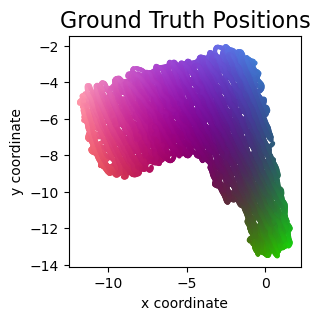

In [3]:
def plot_colorized(positions, groundtruth_positions, title = None, show = True, alpha = 1.0):
    # Generate RGB colors for datapoints
    center_point = np.zeros(2, dtype = np.float32)
    center_point[0] = 0.5 * (np.min(groundtruth_positions[:, 0], axis = 0) + np.max(groundtruth_positions[:, 0], axis = 0))
    center_point[1] = 0.5 * (np.min(groundtruth_positions[:, 1], axis = 0) + np.max(groundtruth_positions[:, 1], axis = 0))
    NormalizeData = lambda in_data : (in_data - np.min(in_data)) / (np.max(in_data) - np.min(in_data))
    rgb_values = np.zeros((groundtruth_positions.shape[0], 3))
    rgb_values[:, 0] = 1 - 0.9 * NormalizeData(groundtruth_positions[:, 0])
    rgb_values[:, 1] = 0.8 * NormalizeData(np.square(np.linalg.norm(groundtruth_positions[:,:2] - center_point, axis=1)))
    rgb_values[:, 2] = 0.9 * NormalizeData(groundtruth_positions[:, 1])

    # Plot datapoints
    plt.figure(figsize=(3, 3))
    if title is not None:
        plt.title(title, fontsize=16)
    plt.scatter(positions[:, 0], positions[:, 1], c = rgb_values, alpha = alpha, s = 10, linewidths = 0)
    plt.xlabel("x coordinate")
    plt.ylabel("y coordinate")
    if show:
        plt.show()

plot_colorized(groundtruth_positions[:,:2], groundtruth_positions[:,:2], title="Ground Truth Positions")

## Estimate Delay Spreads

In [4]:
def estimate_delayspreads(csi_fd):

    delayspreads = []

    for i in range(csi_fd.shape[0]):
        csi = np.fft.fftshift(np.fft.ifft(np.fft.fftshift(csi_fd[i], axes=-1)),axes=-1)
        csi_by_array = np.reshape(csi, (np.shape(csi)[0], 8, np.shape(csi)[3]))
        powers = np.square(np.abs(csi_by_array))
        
        timestamps = np.arange(np.shape(csi_by_array)[2], dtype = np.float32) / spec["bandwidth"]
        time_weighted_powers = np.einsum("amt,t->amt", powers, timestamps)
        mean_delays = np.divide(np.sum(time_weighted_powers, axis = 2), np.sum(powers, axis = 2))
        squared_delays = np.square(timestamps[np.newaxis, np.newaxis, :] - mean_delays[:, :, np.newaxis])
        delayspreads.append(np.sqrt(np.divide(np.sum(np.multiply(squared_delays, powers), axis = 2), np.sum(powers, axis = 2))))

    return np.mean(np.array(delayspreads), axis = -1)

In [5]:
delayspreads_RAW_test = estimate_delayspreads(csi_freq_domain_RAW_test)
delayspreads_RAW_RECOVERED_test = estimate_delayspreads(csi_freq_domain_RAW_RECOVERED_test)
delayspreads_OBFUSCATED_test = estimate_delayspreads(csi_freq_domain_OBFUSCATED_test)
delayspreads_RECOVERED_test = estimate_delayspreads(csi_freq_domain_RECOVERED_test)

## AoA Estimation

In [6]:
# Retrieve antenna array positions and normal vectors
array_positions = np.zeros((len(spec["antennas"]), 3))
array_normalvectors = np.zeros((len(spec["antennas"]), 3))

for antidx, antenna in enumerate(spec["antennas"]):
    array_positions[antidx] = np.asarray(antenna["location"])
    array_normalvectors[antidx] = np.asarray(antenna["direction"])

HEIGHT = np.mean(groundtruth_positions_test[:,2])
print(HEIGHT)

0.9380000270541465


In [7]:
def get_unitary_rootmusic_estimator(chunksize = 32, shed_coeff_ratio = 0):
    I = np.eye(chunksize // 2)
    J = np.flip(np.eye(chunksize // 2), axis = -1)
    Q = np.asmatrix(np.block([[I, 1.0j * I], [J, -1.0j * J]]) / np.sqrt(2))
    
    def unitary_rootmusic(R):
        assert(len(R) == chunksize)
        C = np.real(Q.H @ R @ Q)
    
        eig_val, eig_vec = np.linalg.eigh(C)
        eig_val = eig_val[::-1]
        eig_vec = eig_vec[:,::-1]

        source_count = 1
        En = eig_vec[:,source_count:]
        ENSQ = Q @ En @ En.T @ Q.H
    
        coeffs = np.asarray([np.trace(ENSQ, offset = diag) for diag in range(1, len(R))])
        coeffs = coeffs[:int(len(coeffs) * (1 - shed_coeff_ratio))]

        # Remove some of the smaller noise coefficients, trade accuracy for speed
        coeffs = np.hstack((coeffs[::-1], np.trace(ENSQ), coeffs.conj()))
        roots = np.roots(coeffs)
        roots = roots[abs(roots) < 1.0]
        largest_root = np.argmax(1 / (1.0 - np.abs(roots)))
        
        return np.angle(roots[largest_root])

    return unitary_rootmusic

def estimate_aoas(csi):
    ANTENNAS_PER_ROW = csi.shape[3]
    umusic = get_unitary_rootmusic_estimator(ANTENNAS_PER_ROW)
    
    estimated_aoas = []
    for i in range(csi.shape[0]):
        R = np.einsum("arms,arns->amn", csi[i,...,:16], np.conj(csi[i,...,:16]))
        estimated_aoas.append([np.arcsin(umusic(R[array]) / np.pi) for array in range(len(R))])
    
    return np.array(estimated_aoas)

In [8]:
# estimate AoAs
aoas_RAW_test = estimate_aoas(csi_freq_domain_RAW_test)
aoas_RAW_RECOVERED_test = estimate_aoas(csi_freq_domain_RAW_RECOVERED_test)
aoas_OBFUSCATED_test = estimate_aoas(csi_freq_domain_OBFUSCATED_test)
aoas_RECOVERED_test = estimate_aoas(csi_freq_domain_RECOVERED_test)

## Triangulation

In [9]:
# Generate grid of potential TX positions, used for initializing optimization algorithm
candidate_xrange = np.linspace(np.min(array_positions[:,0]) - 5, np.max(array_positions[:,0]) + 5, 100)
candidate_yrange = np.linspace(np.min(array_positions[:,1]) - 5, np.max(array_positions[:,1]) + 5, 100)
candidate_initial_positions = np.transpose(np.meshgrid(candidate_xrange, candidate_yrange, HEIGHT)).reshape(-1, 3)

In [10]:
# These are some empirically determined heuristics, may be further tweaked
def get_aoa_vonmises_kappas(delayspreads):
    return 0.0000003 / (delayspreads + 0.025e-7)

def get_likelihood_function(aoa_datapoint, rms_delay_spreads):
    def likelihood_func(parameters):
        # "relative" has shape (number of positions, number of arrays, 3 spatial dimensions)
        relative_pos = parameters[:,np.newaxis,:3] - array_positions

        # Compute ideal 2D AoAs at given positions, shape: (number of positions, number of arrays)
        ideal_aoas = np.arctan2(-relative_pos[:, :, 1], -relative_pos[:, :, 0]) - np.arctan2(-array_normalvectors[:, 1], -array_normalvectors[:, 0])

        # Compute AoA likelihoods based on von Mises distribution
        kappa = get_aoa_vonmises_kappas(rms_delay_spreads)
        aoa_likelihoods = np.exp(kappa * np.cos(ideal_aoas - aoa_datapoint)) / (2 * np.pi * np.i0(kappa))

        return np.product(aoa_likelihoods, axis = -1)

    return likelihood_func

def estimate_position_aoa(estimated_aoas, delayspreads):
    
    positions = []
    likelihoods = []

    for index in range(estimated_aoas.shape[0]):

        aoa_datapoint = estimated_aoas[index]
        ds_datapoint = delayspreads[index]
    
        likelihood_func = get_likelihood_function(aoa_datapoint, ds_datapoint)
    
        # Find most likely initialization position based on AoA
        initial_point = candidate_initial_positions[np.argmax(likelihood_func(candidate_initial_positions))]
    
        # Use scipy.optimize to find most likely TX position
        init_value = np.asarray([initial_point[0], initial_point[1]])
        optimize_res = scipy.optimize.minimize(lambda pos_and_time : -likelihood_func(np.asarray([[pos_and_time[0], pos_and_time[1], HEIGHT]])), init_value, options = {"gtol": 1e-7})
    
        positions.append(np.asarray([optimize_res.x[0], optimize_res.x[1]]))
        likelihoods.append(-optimize_res.fun)

    return np.array(positions)

In [11]:
# estimate positions based on AoAs and triangulation
aoa_positions_RAW_test = estimate_position_aoa(aoas_RAW_test, delayspreads_RAW_test)
aoa_positions_RAW_RECOVERED_test = estimate_position_aoa(aoas_RAW_RECOVERED_test, delayspreads_RAW_RECOVERED_test)
aoa_positions_OBFUSCATED_test = estimate_position_aoa(aoas_OBFUSCATED_test, delayspreads_OBFUSCATED_test)
aoa_positions_RECOVERED_test = estimate_position_aoa(aoas_RECOVERED_test, delayspreads_RECOVERED_test)

## Visualize Results

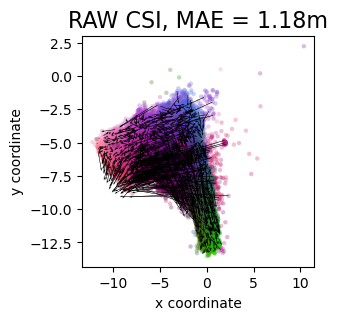

<Figure size 640x480 with 0 Axes>

In [12]:
# Calculate errors and plot results for RAW CSI
errorvectors = groundtruth_positions_test[:,:2] - aoa_positions_RAW_test[:,:2]
errors_RAW_test = np.sqrt(errorvectors[:,0]**2 + errorvectors[:,1]**2)
mae = np.round(np.mean(errors_RAW_test), 2)

nth_errorvector = 15
plot_colorized(aoa_positions_RAW_test[:,:2], groundtruth_positions_test[:,:2], title = "RAW CSI, MAE = " + str(mae) + "m", show = False, alpha = 0.3)
plt.quiver(aoa_positions_RAW_test[::nth_errorvector, 0], aoa_positions_RAW_test[::nth_errorvector, 1], errorvectors[::nth_errorvector, 0], errorvectors[::nth_errorvector, 1], color = "black", angles = "xy", scale_units = "xy", scale = 1)
plt.savefig("results/aoa/aoa_errors_RAW_test",bbox_inches='tight',dpi=300)
plt.show()
plt.clf()

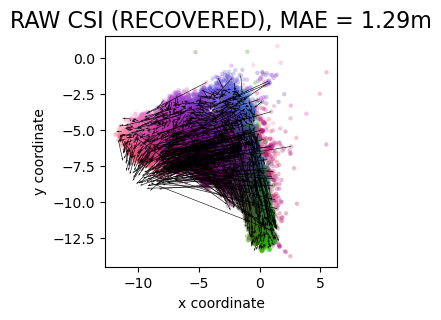

<Figure size 640x480 with 0 Axes>

In [13]:
# Calculate errors and plot results for OBFUSCATED CSI (RECOVERED)
errorvectors = groundtruth_positions_test[:,:2] - aoa_positions_RAW_RECOVERED_test[:,:2]
errors_RAW_RECOVERED_test = np.sqrt(errorvectors[:,0]**2 + errorvectors[:,1]**2)
mae = np.round(np.mean(errors_RAW_RECOVERED_test), 2)

nth_errorvector = 15
plot_colorized(aoa_positions_RAW_RECOVERED_test[:,:2], groundtruth_positions_test[:,:2], title = "RAW CSI (RECOVERED), MAE = " + str(mae) + "m", show = False, alpha = 0.3)
plt.quiver(aoa_positions_RAW_RECOVERED_test[::nth_errorvector, 0], aoa_positions_RAW_RECOVERED_test[::nth_errorvector, 1], errorvectors[::nth_errorvector, 0], errorvectors[::nth_errorvector, 1], color = "black", angles = "xy", scale_units = "xy", scale = 1)
plt.savefig("results/aoa/aoa_errors_RAW_RECOVERED_test",bbox_inches='tight',dpi=300)
plt.show()
plt.clf()

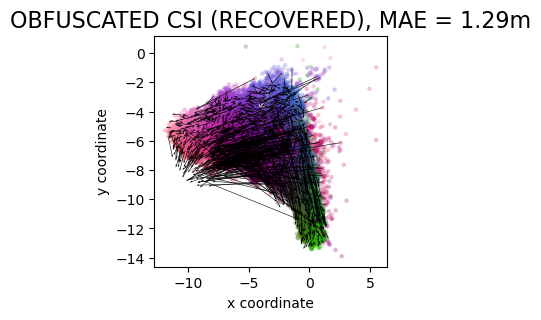

<Figure size 640x480 with 0 Axes>

In [14]:
# Calculate errors and plot results for OBFUSCATED CSI (RECOVERED)
errorvectors = groundtruth_positions_test[:,:2] - aoa_positions_RECOVERED_test[:,:2]
errors_RECOVERED_test = np.sqrt(errorvectors[:,0]**2 + errorvectors[:,1]**2)
mae = np.round(np.mean(errors_RECOVERED_test), 2)

nth_errorvector = 15
plot_colorized(aoa_positions_RECOVERED_test[:,:2], groundtruth_positions_test[:,:2], title = "OBFUSCATED CSI (RECOVERED), MAE = " + str(mae) + "m", show = False, alpha = 0.3)
plt.quiver(aoa_positions_RECOVERED_test[::nth_errorvector, 0], aoa_positions_RECOVERED_test[::nth_errorvector, 1], errorvectors[::nth_errorvector, 0], errorvectors[::nth_errorvector, 1], color = "black", angles = "xy", scale_units = "xy", scale = 1)
plt.savefig("results/aoa/aoa_errors_RECOVERED_test",bbox_inches='tight',dpi=300)
plt.show()
plt.clf()

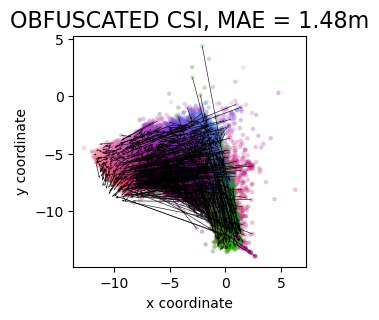

<Figure size 640x480 with 0 Axes>

In [15]:
# Calculate errors and plot results for OBFUSCATED CSI
errorvectors = groundtruth_positions_test[:,:2] - aoa_positions_OBFUSCATED_test[:,:2]
errors_OBFUSCATED_test = np.sqrt(errorvectors[:,0]**2 + errorvectors[:,1]**2)
mae = np.round(np.mean(errors_OBFUSCATED_test), 2)

nth_errorvector = 15
plot_colorized(aoa_positions_OBFUSCATED_test[:,:2], groundtruth_positions_test[:,:2], title = "OBFUSCATED CSI, MAE = " + str(mae) + "m", show = False, alpha = 0.3)
plt.quiver(aoa_positions_OBFUSCATED_test[::nth_errorvector, 0], aoa_positions_OBFUSCATED_test[::nth_errorvector, 1], errorvectors[::nth_errorvector, 0], errorvectors[::nth_errorvector, 1], color = "black", angles = "xy", scale_units = "xy", scale = 1)
plt.savefig("results/aoa/aoa_errors_OBFUSCATED_test",bbox_inches='tight',dpi=300)
plt.show()
plt.clf()